In [20]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [128]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=10000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    #print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        return np.linalg.solve(A, b)
        #return gauss_seidel(A, b, -b)
        #return np.linalg.pinv(A).dot(b) 

### Advection-Transport

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} + \mathbf{v} \cdot \nabla u = f 
$

where

$\nabla \cdot \mathbf{v} = 0$ (incompressible flow)


#### Courant–Friedrichs–Lewy number

$
CFL = \frac{\displaystyle v \Delta t}{\displaystyle \Delta x}  \hspace{0.5cm} \text{one dimentional}\\
CFL \le 1
$


In [188]:
# (solve Au=f for each time step) 

class Transport: 
    """
    Finite difference solution of the Advection/Transport equation (hyperbolic equation)

    Parameters
    ----------
    velocity: float
        Velocity in m/s
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet', 'Neumann' or 'periodic'), e.g. ['Dirichlet','Neumann'] or ['periodic','periodic']  
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    space_discretization: str | default 'upwind'
        Space discretization (options: central or upwind), e.g. 'upwind'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the transport equation for one time step of size dt considering the source term

    """  
    def __init__(self, velocity, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit', space_discretization='upwind'):   
        self.velocity = velocity
        self.dx = dx 
        self.N = N  
        self.u_previous = np.array(initial_condition) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.time_integration = time_integration 
        self.space_discretization = space_discretization
        self.timestep_count = 0
        if time_integration == 'implicit' or time_integration == 'Crank-Nicolson':
            self.A = np.empty((N,N))
            self.f = np.empty(N)
        if space_discretization == 'upwind':
            self.w = 1. if velocity>0 else 0.
        elif space_discretization == 'central':
            self.w = 0.5
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')            
    
    # Solve the PDE discretized equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        if self.w == 0.5:
            print('***WARNING central space discretization explicit in time is UNSTABLE!')
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        # Calculate advection term for elements not in the boundary
        for i in range(1,self.N-1): 
            u[i] += -cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)
  
        # Calculate advection term for elements in the boundaries 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)          
        elif self.boundary_type[0] == 'Neumann':
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
        elif self.boundary_type[0] == 'periodic':
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)              
        else:
            print('Left boundary: no condition satisfaed!')    
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            u[-1] += -cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                     
        elif self.boundary_type[1] == 'Neumann':
            u[-1] += -cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)     
        elif self.boundary_type[1] == 'periodic':
            u[-1] += -cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                   
        else:
            print('Left boundary: no condition satisfaed!')                            
                
        return u

    # Solve the PDE discretized equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        if self.w == 0.5:
            print('***WARNING central space discretization implicit in time generates oscilations!') 
            
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A[:] = np.diag([1-cfl*(1-self.w)+cfl*self.w]*self.N,  0)  # Main diagonal
        self.A += np.diag([cfl*(1-self.w)]*(self.N-1), 1)              # Upper diagonal
        self.A += np.diag([-cfl*self.w]*(self.N-1),-1)                 # Lower diagonal                
        #
        ## Source term plus constants f
        self.f[:] = self.u_previous + dt*source_term            
        
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] += self.boundary_values[0]*cfl*self.w                  
        elif self.boundary_type[0] == 'Neumann':
            self.f[0]  += -self.boundary_values[0]*cfl*self.dx*self.w   
            self.A[0,0] += -cfl*self.w     
        elif self.boundary_type[0] == 'periodic':
            self.A[0,-1] += -cfl*self.w             
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] += -self.boundary_values[-1]*cfl*(1-self.w)              
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] += -self.boundary_values[-1]*cfl*self.dx*(1-self.w)  
            self.A[-1,-1] += cfl*(1-self.w)     
        elif self.boundary_type[1] == 'periodic':
            self.A[-1,0] += cfl*(1-self.w)                
        else:
            print('Right boundary: no condition satisfaed!')         
         
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u
    
    # Solve the PDE discretized equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        if self.w == 0.5:
            print('***WARNING central space discretization Crank-Nicolson in time generates oscilations!') 
        else:
            print('***WARNING Crank-Nicolson in time may generate oscilations!') 
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx   
                        
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A[:] = np.diag([1-theta*cfl*(1-self.w)+theta*cfl*self.w]*self.N,  0)  # Main diagonal
        self.A += np.diag([theta*cfl*(1-self.w)]*(self.N-1), 1)                    # Upper diagonal
        self.A += np.diag([-theta*cfl*self.w]*(self.N-1),-1)                       # Lower diagonal             
        #
        ## Source term plus constants f
        self.f[:] = self.u_previous + dt*source_term
        for i in range(1,self.N-1):
            self.f[i] += -(1-theta)*cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)      
        
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)
            self.f[0] += theta*self.boundary_values[0]*cfl*self.w               
        elif self.boundary_type[0] == 'Neumann':
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
            self.f[0] += -theta*self.boundary_values[0]*cfl*self.dx*self.w 
            self.A[0,0] += -theta*cfl*self.w 
        elif self.boundary_type[0] == 'periodic':
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)                
            self.A[0,-1] += -theta*cfl*self.w                    
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] += -(1-theta)*cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*(1-self.w)        
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] += -(1-theta)*cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*self.dx*(1-self.w) 
            self.A[-1,-1] += theta*cfl*(1-self.w)
        elif self.boundary_type[1] == 'periodic':
            self.f[-1] += -(1-theta)*cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                
            self.A[-1,0] += theta*cfl*(1-self.w)                                
        else:
            print('Right boundary: no condition satisfaed!')
          
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the transport equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """          
        source_term = np.array(self.N*[0]) if source_term == None else np.array(source_term)
        
        if self.time_integration == 'implicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous[:] = u
            
        elif self.time_integration == 'Crank-Nicolson':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, total time = {self.timestep_count*dt}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous[:] = u            
        
        elif self.time_integration == 'explicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}{"(***WARNING cfl>1)" if self.velocity*dt/self.dx > 1.0 else ""}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous[:] = u
            
        else:
            print(f'Time integration {self.time_integration} NOT available!')
            return None
        
        return u

### Solve implicit

In [204]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=110, #110 
            initial_condition = 40*[10.]+30*[0.]+40*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='implicit',
            space_discretization='upwind')

In [205]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 5s, cfl = 5.00, total time = 5s
Time step 2 => dt = 5s, cfl = 5.00, total time = 10s
Time step 3 => dt = 5s, cfl = 5.00, total time = 15s
Time step 4 => dt = 5s, cfl = 5.00, total time = 20s
Time step 5 => dt = 5s, cfl = 5.00, total time = 25s
0.00416111946105957


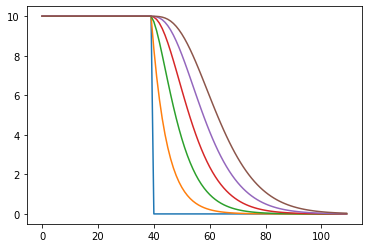

In [206]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_imp = u

A = 
 [[ 1.  0.  0. ...  0.  0.  0.]
 [-5.  6.  0. ...  0.  0.  0.]
 [ 0. -5.  6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  0. ... -5.  6.  0.]
 [ 0.  0.  0. ...  0. -5.  6.]]

u = 
 [10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.          9.99871399  9.99335562
  9.97995971  9.95391208  9.91049938  9.84538033  9.75493721  9.63649978
  9.48845299  9.31024853  9.10234333  8.86608741  8.60358084  8.31751598
  8.01101792  7.68749219  7.35048622  7.00356831  6.650226    6.29378419
  5.93734238  5.58372947  5.23547434  4.89478997  4.56356905  4.24338884
  3.93552324  3.64096048  3.36042452  3.

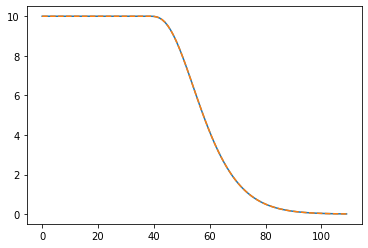

In [148]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.          9.99871399  9.99335562
  9.97995971  9.95391208  9.91049938  9.84538033  9.75493721  9.63649978
  9.48845299  9.31024853  9.10234333  8.86608741  8.60358084  8.31751598
  8.01101792  7.68749219  7.35048622  7.00356831  6.650226    6.29378419
  5.93734238  5.58372947  5.23547434  4.89478997  4.56356905  4.24338884
  3.93552324  3.64096048  3.36042452  3.09439904  2.84315275  2.60676511
  2.3851517   2.17808867  1.98523584  1.80615822  1.64034561  1.48723035
  1.34620315  1.21662687  1.09784861  0.98920996  0.89005564  0.79974066
  0.71763613  0.64313387  

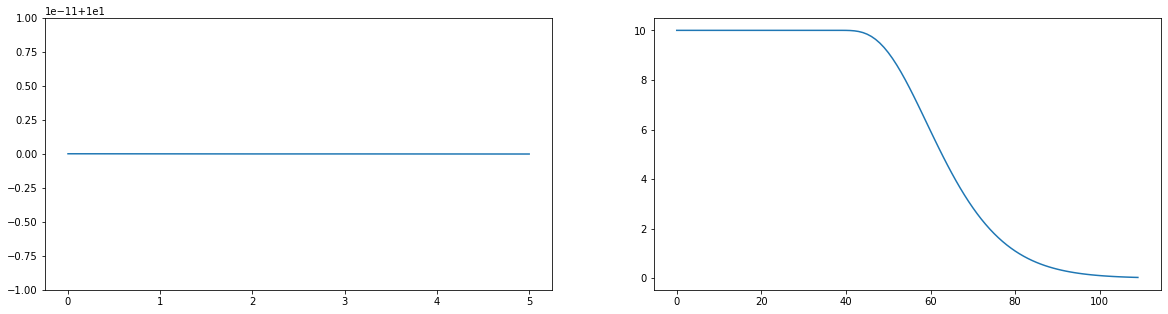

In [149]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

In [150]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=110, #110
            initial_condition = 40*[10.]+30*[0.]+40*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)),
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='explicit',
            space_discretization='upwind')

In [151]:
print(f'Greatest time step explicit = {transport.dx/transport.velocity:.2f}s')

Greatest time step explicit = 1.00s


In [152]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 5s, cfl = 5.00(***WARNING cfl>1), total time = 5s
Time step 2 => dt = 5s, cfl = 5.00(***WARNING cfl>1), total time = 10s
Time step 3 => dt = 5s, cfl = 5.00(***WARNING cfl>1), total time = 15s
Time step 4 => dt = 5s, cfl = 5.00(***WARNING cfl>1), total time = 20s
Time step 5 => dt = 5s, cfl = 5.00(***WARNING cfl>1), total time = 25s
0.0021016597747802734


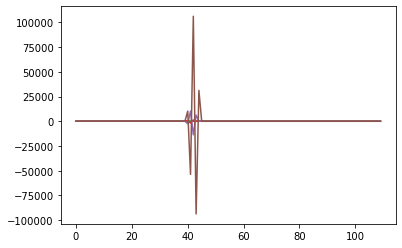

In [153]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=5, # seconds
                               #source_term=4*[0.]+3*[0.]+4*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_exp = u

[ 1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0250e+04 -5.3750e+04
  1.0625e+05 -9.3750e+04  3.1250e+04  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0

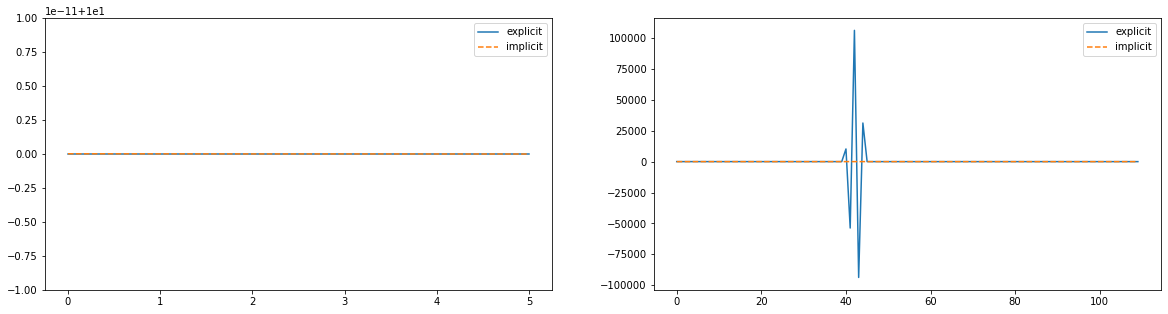

In [154]:
print(u_exp[-1])
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].legend(['explicit','implicit'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].legend(['explicit','implicit'])

### Solve Crank-Nicolson

In [189]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=110, #110 
            initial_condition = 40*[10.]+30*[0.]+40*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='Crank-Nicolson',
            space_discretization='upwind')

In [190]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 5s, cfl = 5.00, total time = 5s
***WARNING Crank-Nicolson in time may generate oscilations!
Time step 2 => dt = 5s, cfl = 5.00, total time = 10s
***WARNING Crank-Nicolson in time may generate oscilations!
Time step 3 => dt = 5s, cfl = 5.00, total time = 15s
***WARNING Crank-Nicolson in time may generate oscilations!
Time step 4 => dt = 5s, cfl = 5.00, total time = 20s
***WARNING Crank-Nicolson in time may generate oscilations!
Time step 5 => dt = 5s, cfl = 5.00, total time = 25s
***WARNING Crank-Nicolson in time may generate oscilations!
0.0062160491943359375


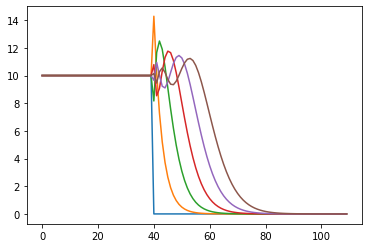

In [191]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_cn = u

A = 
 [[ 1.   0.   0.  ...  0.   0.   0. ]
 [-2.5  3.5  0.  ...  0.   0.   0. ]
 [ 0.  -2.5  3.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  3.5  0.   0. ]
 [ 0.   0.   0.  ... -2.5  3.5  0. ]
 [ 0.   0.   0.  ...  0.  -2.5  3.5]]

u = 
 [1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
 1.01445826e+01 9.45609397e+00 1.02757233e+01 1.05489331e+01
 1.02236834e+01 9.71877186e+00 9.37582145e+00 9.33856878e+00
 9.58933896e+00 1.00218801e

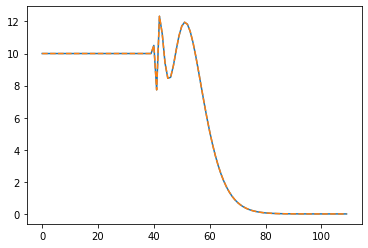

In [158]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[ 1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01
  1.0000e+01  1.0000e+01  1.0000e+01  1.0000e+01  1.0250e+04 -5.3750e+04
  1.0625e+05 -9.3750e+04  3.1250e+04  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0

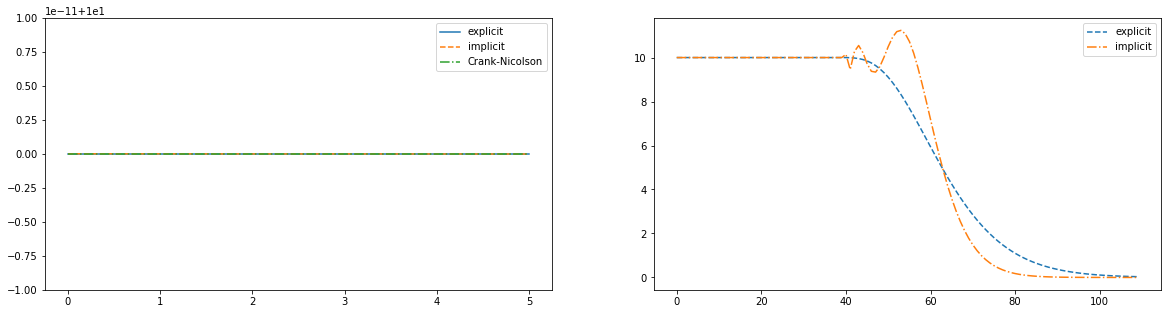

In [159]:
print(u_exp[-1])
print(u_imp[-1])
print(u_cn[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].plot(np.array(u_cn)[:,5],'-.')
axes[0].legend(['explicit','implicit','Crank-Nicolson'])
#axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].plot(u_cn[-1],'-.')
axes[1].legend(['explicit','implicit','Crank-Nicolson'])